In [2]:
#| default_exp hooks

In [3]:
#|export
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import fastcore.all as fc
from functools import partial

from miniai.plotting import *
from miniai.callbacks import to_cpu

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor, optim
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy, Mean
import random
from functools import partial
from miniai.learner import *

from miniai.data import *
from miniai.learner import *
from miniai.callbacks import *
from miniai.custom_modules import conv
from miniai.plotting import subplots, show_image

In [4]:
Learner??

In [5]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [6]:
X_train = tensor(data.iloc[:50000, 1:].values)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = tensor(data.iloc[50000:, 1:].values)
y_valid = tensor(data.iloc[50000:, 0].values)

In [7]:
dset_train = Dataset((X_train[:2000]/255. ).view(-1, 1, 28, 28), y_train[:2000])
dset_valid = Dataset((X_valid[:500]/255. ).view(-1, 1, 28, 28), y_valid[:500])

In [8]:
dl_train = DataLoader(dset_train, batch_size=64, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False)

In [9]:
dls = DataLoaders(dl_train, dl_valid)

<br>**Model with hooks**

In [4]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
#|export
def get_hist(hook, rng=None):
    """rng: tuple (i1, i2), which tells the range of iterations from which we get stats"""
    if rng is None: return torch.flip(torch.stack(hook.stats[2]).T, [0]).log1p()
    return torch.flip(torch.stack(hook.stats[2][rng[0]:rng[1]]).T, [0]).log1p()
def get_dead_ratio(hook, rng=None):
    """rng: tuple (i1, i2), which tells the range of iterations from which we get stats"""
    h = torch.stack(hook.stats[2]) if rng is None else torch.stack(hook.stats[2][rng[0]:rng[1]])
    res = h[:, 0]/(h[:, 1:].sum(1))
    return res

In [6]:
#|export
class Hook:
    def __init__(self, layer, f): self.hook = layer.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

class Hooks(list):
    def __init__(self, layers, f, layers_names=None): 
        super().__init__([Hook(l, f) for l in layers])
        self.layers_names = [type(l).__name__ for l in layers] if layers_names is None else layers_names
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.remove()
    def __delitem__(self, i):
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()
    
    def plot_means_stds(self, rng=None):
        """rng: tuple (i1, i2), which tells the range of iterations from which we get stats"""
        fig, ax = subplots(nrows=1, ncols=2, imsize=(5, 4))
        for hook in self:
            ax[0].plot(hook.stats[0] if rng is None else hook.stats[0][rng[0]:rng[1]])
            ax[1].plot(hook.stats[1] if rng is None else hook.stats[1][rng[0]:rng[1]])
        plt.legend(range(len(self)))
        ax[0].set_title('Means'); ax[1].set_title('Stds')
        plt.tight_layout(); plt.show()
    def plot_acts(self, ls=None, rng=None):
        """ls: list of layers names
           rng: tuple (i1, i2), which tells the range of iterations from which we get stats"""
        if ls is None: ls = list(range(len(self)))
        show_images([get_hist(self[l], rng) for l in ls], [f'{l}_{self.layers_names[l]}' for l in ls], imsize=(3, 2), cmap='viridis')
        plt.tight_layout(); plt.show()
    def plot_dead_charts(self, ls=None, rng=None):
        """ls: list of layers names
           rng: tuple (i1, i2), which tells the range of iterations from which we get stats"""
        if ls is None: ls = list(range(len(self)))
        fig, ax = subplots(len(ls), imsize=(3, 2))
        for l in ls:
            ax[l].plot(get_dead_ratio(self[l], rng)); ax[l].set_title(f'{l}_{self.layers_names[l]}')
        plt.tight_layout(); plt.show()

In [7]:
#|export
def append_stats(hook, mod, inp, out, hist_params=[40, 0, 10]):
    if not hasattr(hook, 'stats'): hook.stats = [[], [], []]
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(*hist_params))

In [14]:
model = nn.Sequential(
    conv(1, 8, ks=5, act=nn.ReLU()), #14×14
    conv(8, 16, act=nn.ReLU()), #7×7
    conv(16, 32, act=nn.ReLU()), #4×4
    conv(32, 64, act=nn.ReLU()), #2×2
    conv(64, 10, act=None), #1×1
    nn.Flatten()
)

In [15]:
metrics = MetricCB(accuracy=MulticlassAccuracy())
learn = TrainLearner(dls, model, F.cross_entropy, optim.Adam, cbs=[metrics, ProgressCB()])

In [16]:
with Hooks(model, append_stats) as hooks:
    learn.fit(2, 1e-3)

epoch,train_loss,valid_loss,accuracy
0,2.115,1.454,0.538
1,1.017,0.877,0.678


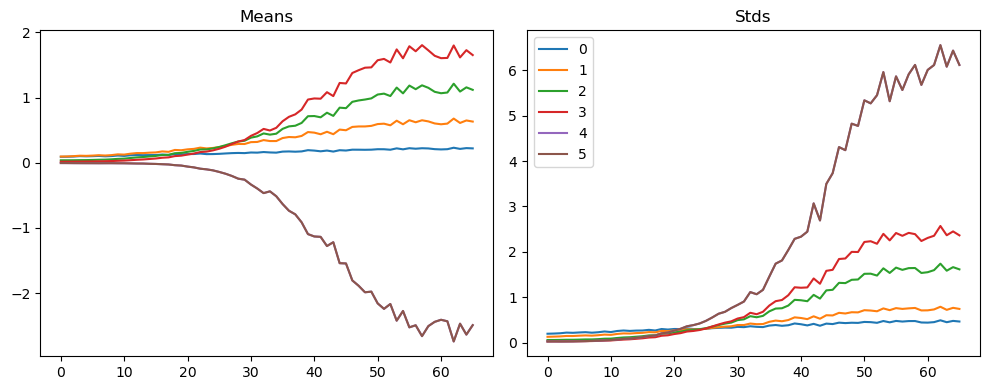

In [17]:
hooks.plot_means_stds()

In [ ]:
hooks.plot_dead_charts(rng=(50, 100))

In [ ]:
hooks.plot_acts(rng=(0, 100))

In [9]:
import nbdev; nbdev.nbdev_export()